In [1]:
# This program uses an artificial recurrent neural network called long short term memory (LSTM) to predict the closing 
# of a corporation (I will be using TSLA Inc.) using the past 60 day stock price

NN?

In [2]:
# import the libraries needed
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
# Get the Stock Quote
df = web.DataReader("AAPL", data_source="yahoo", start="2012-01-01", end = "2022-09-20")
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.540047
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.607435
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.747405
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.880668
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.860232
...,...,...,...,...,...,...
2022-09-14,157.100006,153.610001,154.789993,155.309998,87965400.0,155.309998
2022-09-15,155.240005,151.380005,154.649994,152.369995,90481100.0,152.369995
2022-09-16,151.350006,148.369995,151.210007,150.699997,162157000.0,150.699997


In [4]:
# Get the number of rows and columns in the dataset
df.shape

(2697, 6)

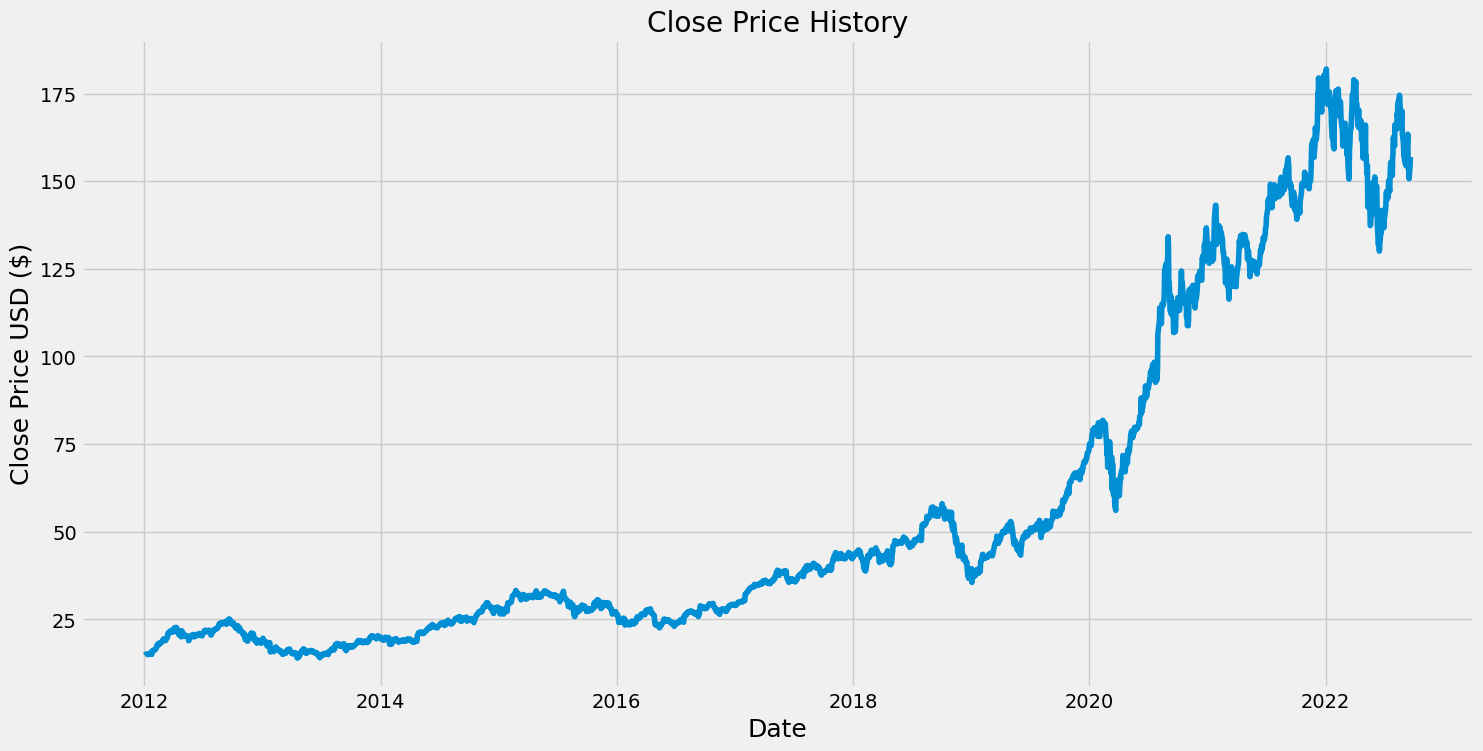

In [5]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD ($)", fontsize = 18)
plt.show()

In [6]:
# Create a new datafram with only close column
data = df.filter(["Close"])
# covert dataframe to numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*0.8)
print(training_data_len)

2158


In [7]:
#Scale the data
# applying preprocessing
scaler = MinMaxScaler(feature_range=(0,1)) # scales the data with min 0 max 1, (i.e minimum value in dataset becomes 0, max becomes 1 rest are scaled according)
scaled_data = scaler.fit_transform(dataset) 
scaled_data

array([[0.00439887],
       [0.00486851],
       [0.00584391],
       ...,
       [0.81370027],
       [0.83619189],
       [0.85059129]])

In [8]:
# Create the training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
# split data into x_train and y_train
x_train = []
y_train = []
for i in range(60, len(train_data)):
    # per pass through, x_train will take first 60 values, and y will take 61st (i.e will use 60 values for predicting target 61st value)
    x_train.append(train_data[i-60:i, 0]) 
    y_train.append(train_data[i,0])

In [9]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [10]:
#Reshape the data, LSTM model expects 3 dim
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [11]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1],1)    ))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
model.compile(optimizer="adam", loss = "mean_squared_error")

In [13]:
#Train the model
model.fit(x_train,y_train, batch_size=1, epochs=1)

2098/2098 [==============================] - 29s 13ms/step - loss: 3.5806e-04


In [14]:
#Create the testing data set
# Create a new array containing scaled values from 1543 to 2003
test_data = scaled_data[training_data_len-60: , :]
#Create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [15]:
# convert data to numpy array
x_test = np.array(x_test)


In [16]:
#reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [17]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # reverse scale the predictions


17/17 [==============================] - 1s 9ms/step


In [18]:
#Get the root MSE 
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2.7757946007326937

C:\Users\Karanpal Sekhon\AppData\Local\Temp\ipykernel_25524\3611443382.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


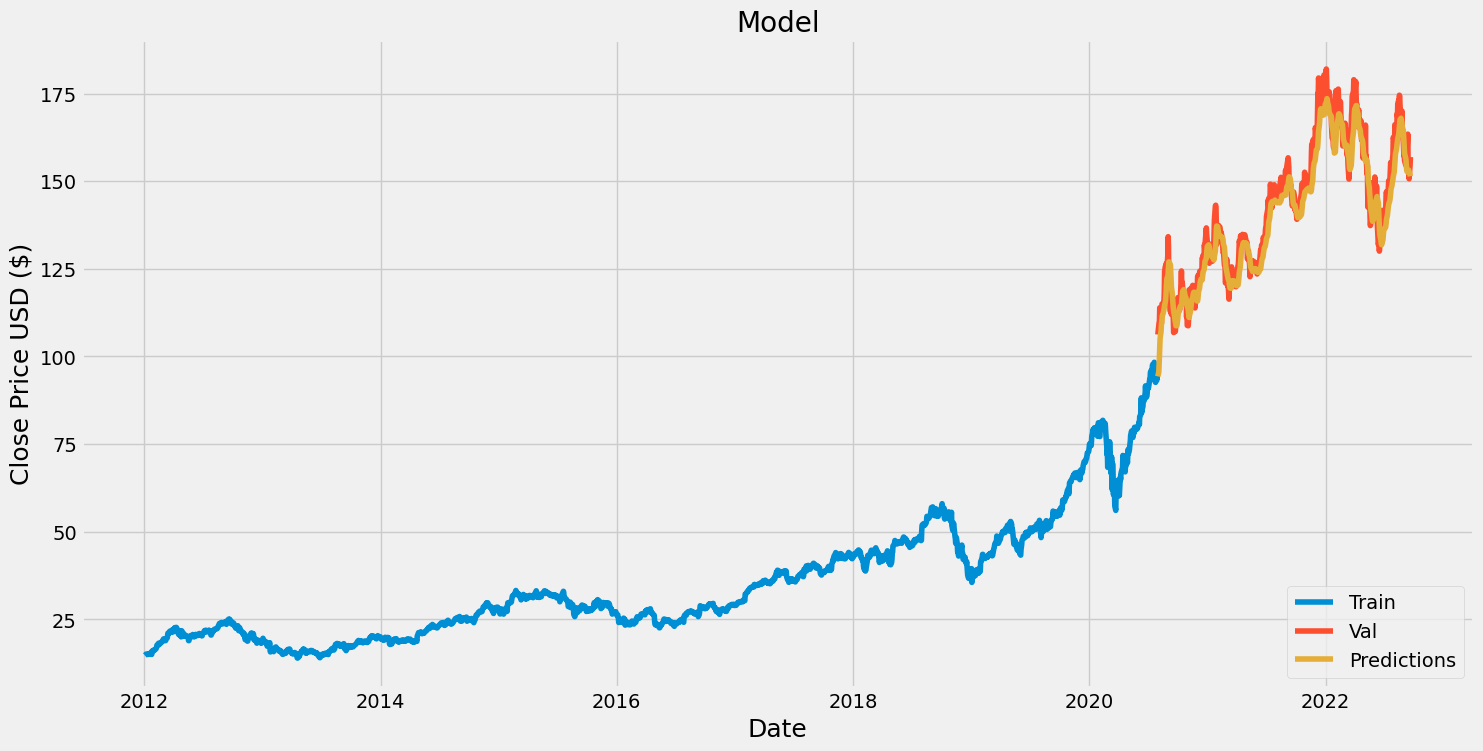

In [19]:
# plt the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD ($)", fontsize = 18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc = "lower right")
plt.show()